In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
%matplotlib inline


def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

D:\3kurs1sem\IDEs\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv(r'd:\DownLoads\WAG_C_M.csv',sep=";", parse_dates=['month'], index_col=['month'],dayfirst=True)

In [3]:
data.rename(columns={'WAG_C_M': 'salary'}, inplace=True)

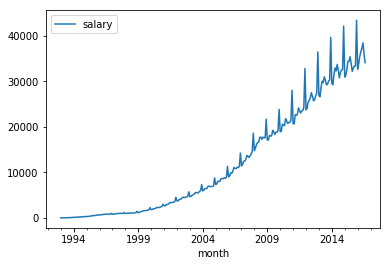

In [4]:
data.plot()

0.9918495954854735

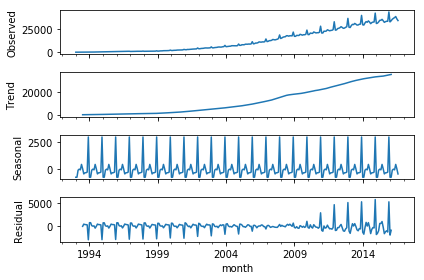

In [5]:
sm.tsa.seasonal_decompose(data.salary).plot()
sm.tsa.stattools.adfuller(data.salary)[1]

0.2632017541844584


0.6968987634832662

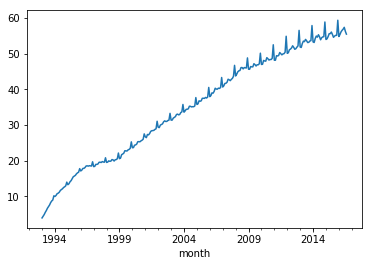

In [6]:
data['salart_box'], lmbda = stats.boxcox(data.salary)
data.salart_box.plot()
print(lmbda)
sm.tsa.stattools.adfuller(data.salart_box)[1]

0.014697133494791775

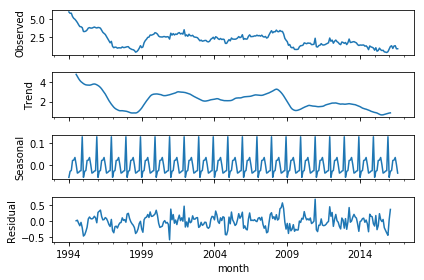

In [7]:
data['salary_box_diff'] = data.salart_box - data.salart_box.shift(12)
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1]

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

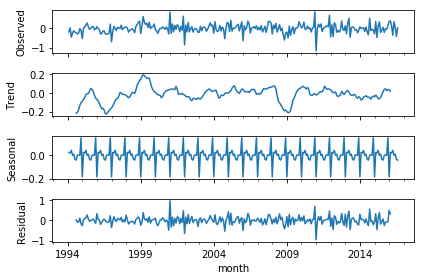

In [10]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

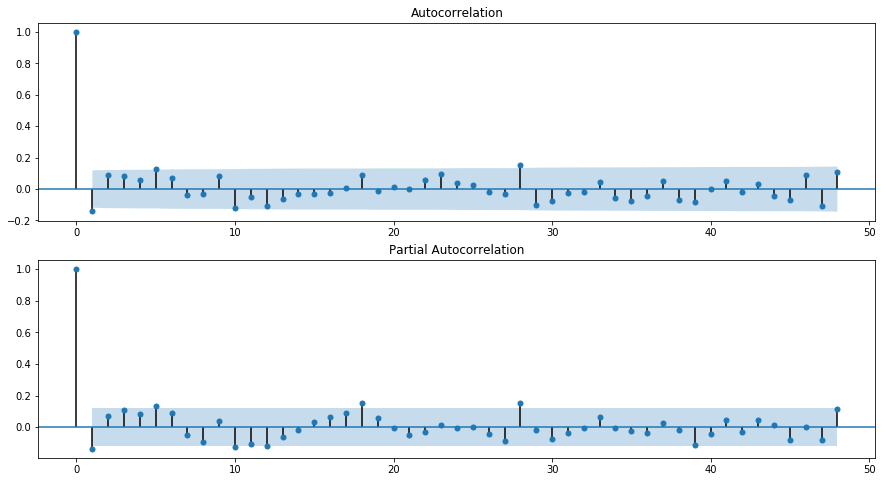

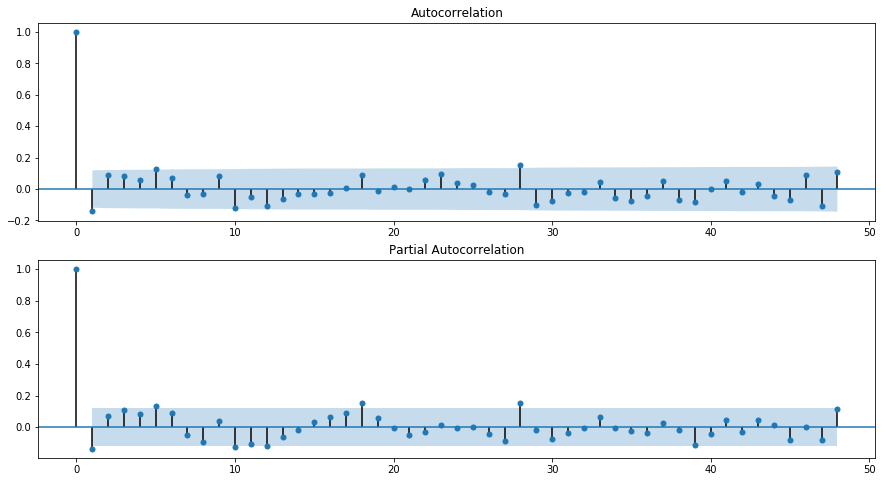

In [14]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)

In [15]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [16]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [17]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salart_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print( 'wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
29  (3, 1, 1, 0) -4.995859
28  (3, 1, 0, 1) -4.342767
30  (3, 1, 1, 1) -4.312789
37  (4, 1, 1, 0) -3.975974
36  (4, 1, 0, 1) -3.362304


In [19]:
print (best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salart_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Fri, 28 Sep 2018   AIC                             -4.996
Time:                                    14:52:53   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4853      0.210      2.311      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Критерий Стьюдента: p=0.281805
Критерий Дики-Фуллера: p=0.000000


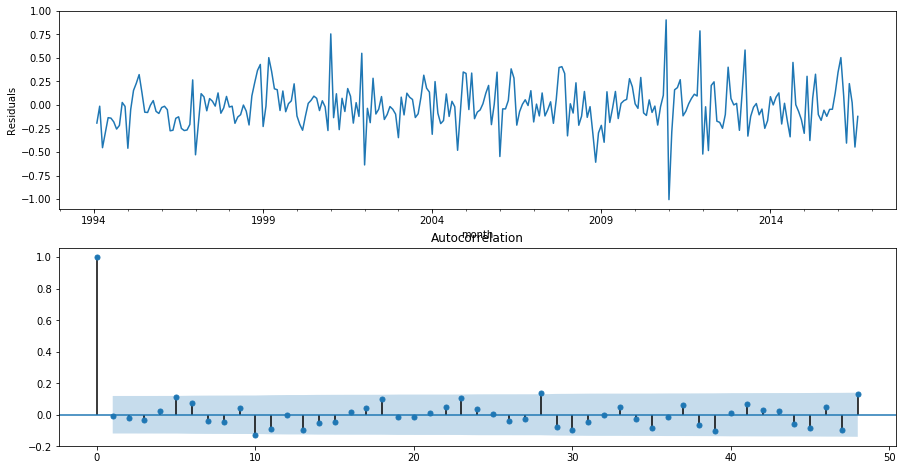

In [21]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [23]:
import numpy as np

Text(0,0.5,'Средние зарплаты')

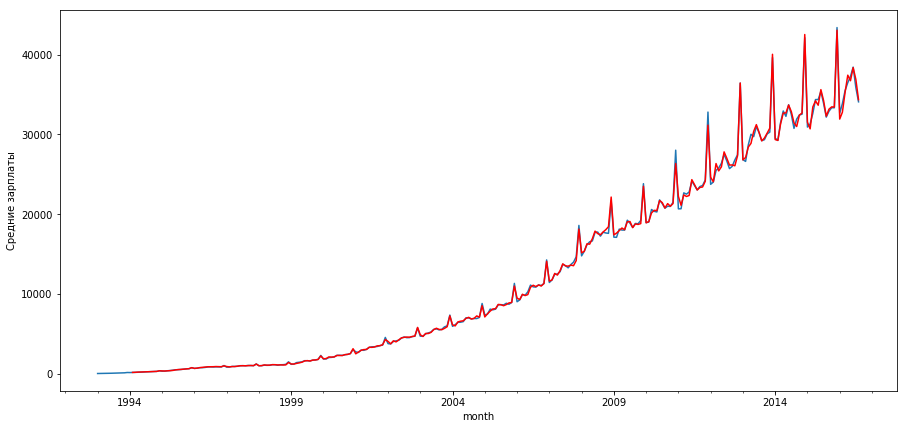

In [26]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Средние зарплаты')


In [34]:
import datetime
from dateutil.relativedelta import relativedelta 

Text(0,0.5,'Средние зарплаты')

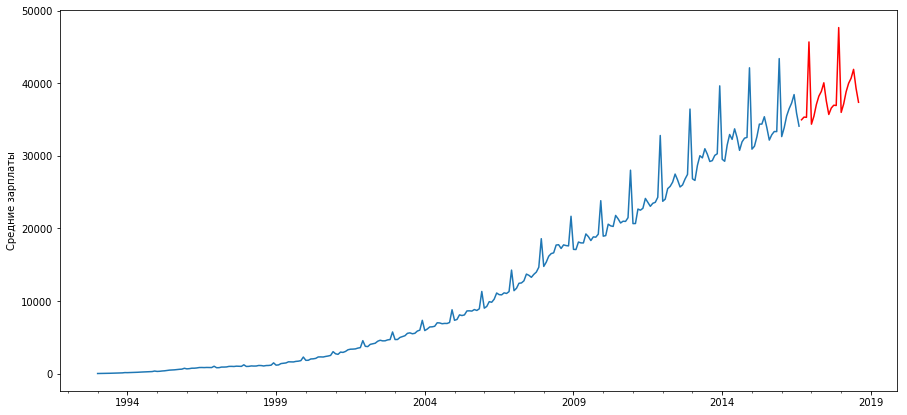

In [36]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize=(15,7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Средние зарплаты')
